**Logistic regression / classification on tennis dataset with Pytorch**

In [135]:
# import packages and load data

import pandas as pd
import numpy as np
import torch
from torch import nn

from sklearn.preprocessing import StandardScaler  # for feature scaling
from sklearn.model_selection import train_test_split  # for train/test split


import matplotlib.pyplot as plt


from scipy import stats

df = pd.read_csv('C:/Users/dgwal/jup_notebook/tennis.csv')
df.head()

,Unnamed: 0,flag,rolling_rank_diff,rolling_rank points_diff,rolling_ace_per_svpt_diff,rolling_df_per_svpt_diff,rolling_1stIn_per_svpt_diff,rolling_1stWon_per_svpt_diff,rolling_2ndWon_per_svpt_diff,rolling_bpSaved_per_svpt_diff,rolling_bpFaced_per_svpt_diff,rolling_bpSaved_per_bpFaced_diff,Elo_diff
0,0,1,34.90000,-760.50000,-0.01423,-0.01371,-0.07728,-0.08082,0.05444,0.02077,0.01596,0.27333,79.444246
1,1,1,-20.41667,1321.25000,0.02177,-0.02151,0.05423,0.04467,-0.02390,0.00738,0.00139,0.14623,9.991456
2,2,0,-3.12821,425.25641,0.02513,-0.01549,0.00616,-0.00185,0.00823,0.00175,-0.00033,0.03552,-51.343844
3,3,0,8.61538,-53.00000,0.00196,-0.00438,-0.01586,-0.02335,0.01013,0.00763,0.00764,0.10385,0.275090
4,4,0,9.90909,84.81818,0.02491,-0.00310,-0.02679,-0.00749,0.02392,-0.00412,-0.00722,-0.02693,-28.233060


In [136]:
# Make device code agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [137]:
# clean data & remove outliers etc
#df.sort_values('rolling_1stIn_per_svpt_diff')

# remove n/a values
mask = ~df.isnull().any(axis=1)
df = df[mask]

# remove outliers (arbitrary z score of 7)
df = df[(np.abs(stats.zscore(df)) < 7).all(axis=1)]



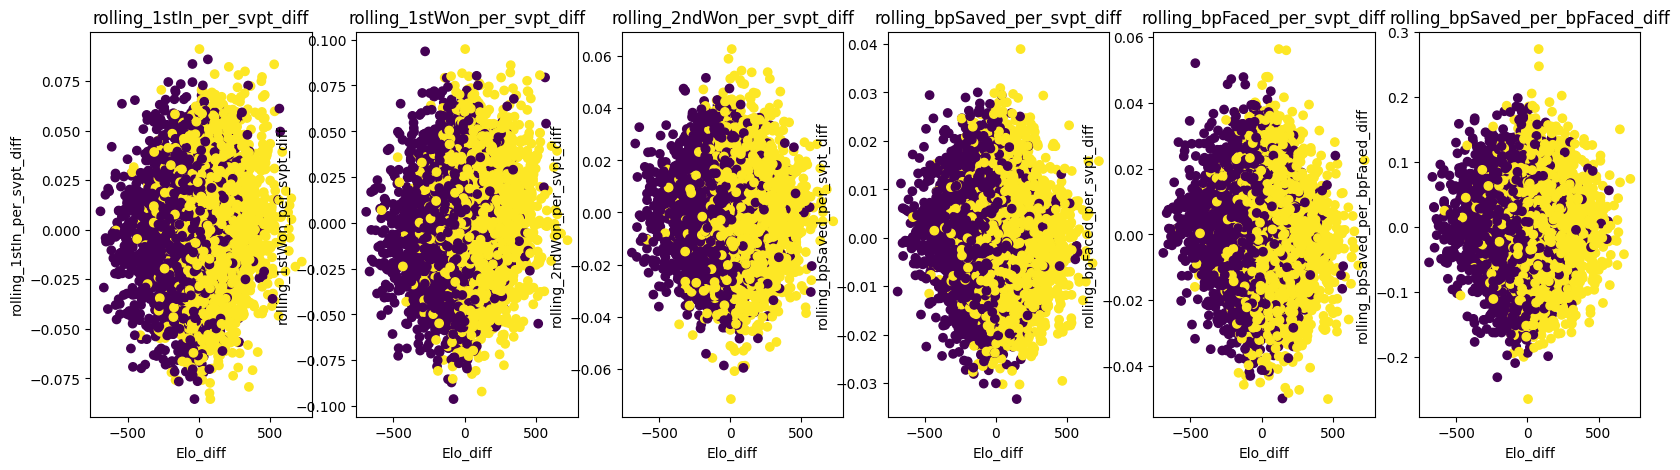

In [138]:
# Let's have a look at some of the variables / relationships in the data...

#plot_cols = df.columns[2:-1]
# for cols in plot_cols:

# plt.scatter(x=X[:, 4], 
#             y=X[:, -1], 
#             c=y, 
#             cmap=plt.cm.RdYlBu);

plot_cols = df.columns[6:-1]

fig, ax = plt.subplots(1, len(plot_cols), figsize = (20, 5))

for idx, col in enumerate(plot_cols):
    ax[idx].scatter(df['Elo_diff'], df[col], c=df['flag'])
    ax[idx].set_ylabel(f'{col}')
    ax[idx].set_xlabel('Elo_diff')
    ax[idx].set_title(col)

plt.show()

# Elo clearly streets ahead of the rest

In [139]:
# convert into numpy arrays
X = df.iloc[:, 2:].to_numpy()
y = df.iloc[:, 1].to_numpy()

print(f"First 4 X features:\n{X[:4]}")
print(f"\nFirst 4 y labels:\n{y[:4]}")

First 4 X features:
[[ 3.49000000e+01 -7.60500000e+02 -1.42300000e-02 -1.37100000e-02
  -7.72800000e-02 -8.08200000e-02  5.44400000e-02  2.07700000e-02
   1.59600000e-02  2.73330000e-01  7.94442457e+01]
 [-2.04166700e+01  1.32125000e+03  2.17700000e-02 -2.15100000e-02
   5.42300000e-02  4.46700000e-02 -2.39000000e-02  7.38000000e-03
   1.39000000e-03  1.46230000e-01  9.99145567e+00]
 [-3.12821000e+00  4.25256410e+02  2.51300000e-02 -1.54900000e-02
   6.16000000e-03 -1.85000000e-03  8.23000000e-03  1.75000000e-03
  -3.30000000e-04  3.55200000e-02 -5.13438437e+01]
 [ 8.61538000e+00 -5.30000000e+01  1.96000000e-03 -4.38000000e-03
  -1.58600000e-02 -2.33500000e-02  1.01300000e-02  7.63000000e-03
   7.64000000e-03  1.03850000e-01  2.75090435e-01]]

First 4 y labels:
[1 1 0 0]


In [140]:
# rescale np arrays 
sc = StandardScaler()
X = sc.fit_transform(X)

# Check the shapes of our features and labels
X.shape, y.shape

((12734, 11), (12734,))

In [141]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [ 1.21967142 -0.67097301 -0.62537758 -1.76785615 -3.45427365 -3.40139565
  3.76238401  2.49914018  1.25883897  4.95139208  0.49996105] and the same for y: 1
Shapes for one sample of X: (11,) and the same for y: ()


In [142]:
# Turn data into tensors
# Otherwise this causes issues with computations later on

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]

(tensor([[ 1.2197e+00, -6.7097e-01, -6.2538e-01, -1.7679e+00, -3.4543e+00,
          -3.4014e+00,  3.7624e+00,  2.4991e+00,  1.2588e+00,  4.9514e+00,
           4.9996e-01],
         [-7.5222e-01,  1.2104e+00,  1.0319e+00, -2.7612e+00,  2.4388e+00,
           1.9233e+00, -1.6412e+00,  8.8094e-01,  9.0699e-02,  2.6459e+00,
           6.0710e-02],
         [-1.3593e-01,  4.0068e-01,  1.1866e+00, -1.9945e+00,  2.8476e-01,
          -5.0628e-02,  5.7500e-01,  2.0054e-01, -4.7201e-02,  6.3767e-01,
          -3.2720e-01],
         [ 2.8270e-01, -3.1557e-02,  1.1995e-01, -5.7966e-01, -7.0198e-01,
          -9.6289e-01,  7.0606e-01,  9.1115e-01,  5.9179e-01,  1.8771e+00,
          -7.4095e-04],
         [ 3.2881e-01,  9.2998e-02,  1.1765e+00, -4.1664e-01, -1.1918e+00,
          -2.8994e-01,  1.6572e+00, -5.0885e-01, -5.9960e-01, -4.9513e-01,
          -1.8104e-01]]),
 tensor([1., 1., 0., 0., 0.]))

In [143]:
# Split data into train and test sets - chronological data so this is a bit meh but let's go with it for now...

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(10187, 2547, 10187, 2547)

In [144]:
# Build model with non-linear activation functions

class TennisModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=X.shape[1], out_features=20)
        #self.relu = nn.ReLU()
        self.layer_2 = nn.Linear(in_features=20, out_features=30)
        #self.relu = nn.ReLU()
        self.layer_3 = nn.Linear(in_features=30, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model 
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.relu(self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x))))))

model_tennis = TennisModel().to(device)
print(model_tennis)

TennisModel(
  (layer_1): Linear(in_features=11, out_features=20, bias=True)
  (layer_2): Linear(in_features=20, out_features=30, bias=True)
  (layer_3): Linear(in_features=30, out_features=1, bias=True)
  (relu): ReLU()
)


In [145]:
# Setup loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_tennis.parameters(), lr=0.1)

In [146]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [147]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_tennis(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_tennis.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_tennis(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calculate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69202, Accuracy: 52.68% | Test Loss: 0.69102, Test Accuracy: 53.59%
Epoch: 100 | Loss: 0.66171, Accuracy: 60.80% | Test Loss: 0.66036, Test Accuracy: 61.25%
Epoch: 200 | Loss: 0.62898, Accuracy: 68.47% | Test Loss: 0.62753, Test Accuracy: 68.51%
Epoch: 300 | Loss: 0.61918, Accuracy: 71.78% | Test Loss: 0.61834, Test Accuracy: 72.36%
Epoch: 400 | Loss: 0.61720, Accuracy: 72.34% | Test Loss: 0.61709, Test Accuracy: 73.03%
Epoch: 500 | Loss: 0.61648, Accuracy: 72.74% | Test Loss: 0.61677, Test Accuracy: 73.07%
Epoch: 600 | Loss: 0.61610, Accuracy: 72.90% | Test Loss: 0.61658, Test Accuracy: 72.95%
Epoch: 700 | Loss: 0.61580, Accuracy: 72.95% | Test Loss: 0.61651, Test Accuracy: 73.14%
Epoch: 800 | Loss: 0.61556, Accuracy: 73.01% | Test Loss: 0.61643, Test Accuracy: 73.30%
Epoch: 900 | Loss: 0.61535, Accuracy: 73.05% | Test Loss: 0.61637, Test Accuracy: 73.14%


**Feature Importance**
Captum package runs a number of algorithms which may help with getting some insight into feature importance / which if any of the derived features are redundant and can be dropped to simplify the model.

In [148]:
import captum

In [149]:
from captum.attr import IntegratedGradients,NoiseTunnel,GradientShap,Occlusion, LayerConductance, NeuronConductance, DeepLift, FeatureAblation

In [150]:
ig = IntegratedGradients(model_3)
ig_nt = NoiseTunnel(ig)
dl = DeepLift(model_3)
gs = GradientShap(model_3)
fa = FeatureAblation(model_3)

ig_attr_test = ig.attribute(X_test, n_steps=50)
ig_nt_attr_test = ig_nt.attribute(X_test)
#dl_attr_test = dl.attribute(X_test)
gs_attr_test = gs.attribute(X_test, X_train)
fa_attr_test = fa.attribute(X_test)

In [151]:
from captum.attr import Saliency

In [152]:
# Defining Saliency interpreter
saliency = Saliency(model_3)
# Computes saliency maps for class 3.
attribution = saliency.attribute(X_test)

c:\Users\dgwal\pytorch_lr\.venv\Lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


In [153]:
attribution.shape

torch.Size([2547, 11])

Average Feature Importances
rolling_rank_diff :  0.080
rolling_rank points_diff :  0.061
rolling_ace_per_svpt_diff :  0.052
rolling_df_per_svpt_diff :  0.056
rolling_1stIn_per_svpt_diff :  0.079
rolling_1stWon_per_svpt_diff :  0.066
rolling_2ndWon_per_svpt_diff :  0.072
rolling_bpSaved_per_svpt_diff :  0.149
rolling_bpFaced_per_svpt_diff :  0.186
rolling_bpSaved_per_bpFaced_diff :  0.071
Elo_diff :  1.486


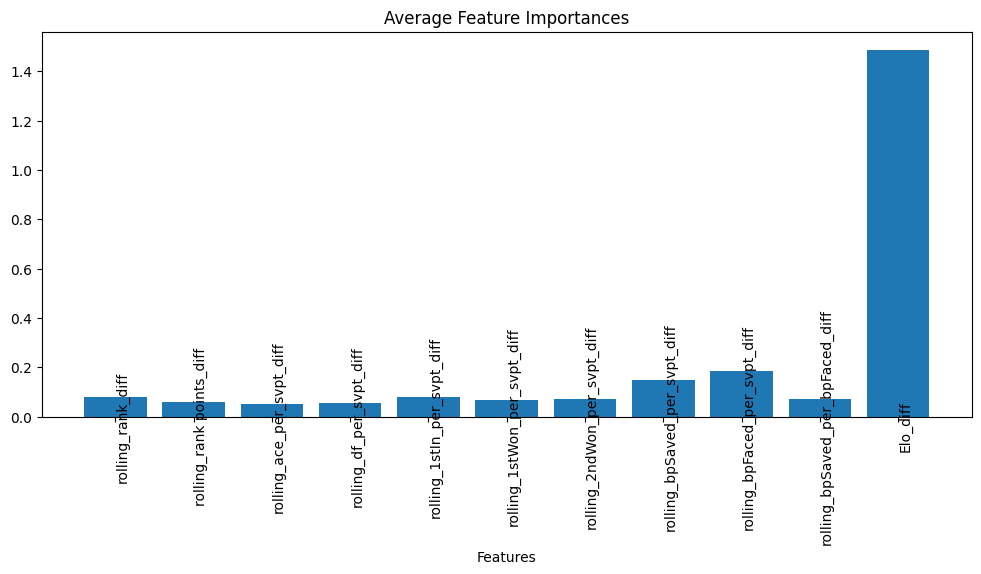

In [154]:
feature_names = df.columns[2:]

# Helper method to print importances and visualize distribution
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,5))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=True, rotation=90)
        plt.xlabel(axis_title)
        plt.title(title)

visualize_importances(feature_names, torch.mean(attribution, axis=0))

In [156]:
torch.mean(attribution, axis=0)

tensor([0.0800, 0.0605, 0.0525, 0.0559, 0.0788, 0.0664, 0.0717, 0.1492, 0.1863,
        0.0709, 1.4857])